In [2]:
import arff

In [39]:
import os
import numpy as np
from scipy.io import arff
from scipy import stats
import pandas as pd

In [40]:

folder_path = "./data/polish_companies_bankruptcy_data"
datasets = []

for i, file_ in enumerate(os.listdir(folder_path)):
    arff_file = arff.loadarff(os.path.join(folder_path, file_))
    df = pd.DataFrame(arff_file[0])
    df["year"] = i + 1
    datasets.append(df)

df_main = pd.concat(datasets)
df_main.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,year
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,b'0',1
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,b'0',1
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,b'0',1
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,b'0',1
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,b'0',1


In [41]:
df_size = len(df_main)
df_size

43405

In [42]:
df_main["class"].value_counts()

class
b'0'    41314
b'1'     2091
Name: count, dtype: int64

## **EDA**

In [43]:
df_main = df_main.apply(pd.to_numeric, errors='coerce')

In [44]:
null_data = df_main.isnull().sum()

null_data_percent = (null_data.values / df_size ) * 100

min(null_data_percent), max(null_data_percent), np.median(null_data_percent), stats.mode(null_data_percent)

(0.0,
 43.73689667089045,
 0.26379449372192143,
 ModeResult(mode=0.01843105632991591, count=15))

**sprawdzamy % nulli w kolumnach**

In [45]:
sorted(null_data_percent, reverse=True)[:5]

[43.73689667089045,
 13.486925469415967,
 6.367929961985946,
 4.957954152747379,
 4.946434742541181]

In [46]:
list(null_data_percent).index(sorted(null_data_percent, reverse=True)[0])

36

**sprawdzenie czy to dobry index**

In [47]:
df_main.columns[36], df_main[df_main.columns[36]].isnull().sum() / df_size

('Attr37', 0.4373689667089045)

`Atrr37` - kolumna do wyzucenia

In [48]:
df_main.drop(columns=df_main.columns[36], inplace=True)

**wartości ujemne**

In [49]:
negatiives = (df_main < 0).sum(axis=0)

print("negative values stats:")
negatives_percent = negatiives.values / df_size * 100
print("max:", max(negatives_percent))
print("median:", np.median(negatives_percent))
print("mode:", stats.mode(np.round(negatives_percent, 2)))

negative values stats:
max: 50.49418269784587
median: 5.8702914410782165
mode: ModeResult(mode=0.01, count=10)


**przy pomocy LLMa przeanalizaowano w których atrybutach mogą pojawić się ujemne wartości**

In [50]:
can_be_negative = "X1, X2, X3, X4, X5, X6, X7, X8, X10, X11, X12, X14, X15, X16, X17, X18, X21, X22, X24, X25, X26, X27, X28, X29, X30, X33, X34, X37, X38, X40, X41, X46, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X59, X62, X63"
can_be_negative = can_be_negative.split(", ")
len(can_be_negative)

45

In [51]:
where_negative_vals = [df_main.columns[i] for i, v in enumerate(negatiives) if v > 0]

**wyciągamy nazwy kolumn gdzie są wartości ujemne a być ich nie powinno**

In [52]:
can_be_negative = [v.replace("X", "Attr") for v in can_be_negative]

wrong_negatives_vals = [v for v in where_negative_vals if v not in can_be_negative]
(wrong_negatives_vals[:5], len(wrong_negatives_vals))

(['Attr9', 'Attr13', 'Attr19', 'Attr20', 'Attr23'], 19)

In [53]:
for atribute in wrong_negatives_vals:
    df_main[atribute] = df_main[atribute].mask(df_main[atribute] < 0, np.nan)

### **zastępujemy NaNy**

In [54]:
df_main = df_main.apply(lambda col: col.fillna(col.median()))

In [55]:
max(df_main.isnull().sum())

0

### **outlier detection**

In [56]:
data_cols = list(df_main.columns)
data_cols.pop(-1)
data_cols.pop(-1)
len(data_cols)

63

In [57]:
z_scores = stats.zscore(df_main[data_cols])
abs_z_scores = np.abs(z_scores)
threshold = 3
filtered_entries = (abs_z_scores < threshold).all(axis=1)

df_clean = df_main[filtered_entries]

In [58]:
print(f"old size: {df_size}")
print(f"new size: {len(df_clean)}")
print(f"removed {df_size - len(df_clean)} outliers")

old size: 43405
new size: 42299
removed 1106 outliers


### **normalizacja**

- normalizujemy wszystkie kolumny oprócz roku i label'a

In [59]:
df_main.columns

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44',
       'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51',
       'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58',
       'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class',
       'year'],
      dtype='object')

In [60]:
print(data_cols)

['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']


In [61]:
df_normalized = df_clean.copy()
df_normalized.reset_index(inplace=True)

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized[data_cols] = scaler.fit_transform(df_clean[data_cols])
df_normalized.head()

,index,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,year
0,1,0.615794,0.035789,0.563816,0.002068,0.471732,0.554839,0.616896,0.001880,0.006591,...,0.509727,0.000101,0.454737,0.000017,0.000388,0.007839,0.006198,0.000213,0,1
1,2,0.637429,0.017995,0.581594,0.004303,0.472103,0.554847,0.643214,0.003039,0.034144,...,0.513441,0.000095,0.454737,0.000048,0.001960,0.005133,0.020784,0.008148,0,1
2,3,0.634513,0.040768,0.558470,0.001764,0.471561,0.554847,0.640011,0.001737,0.026972,...,0.517689,0.000091,0.455594,0.000058,0.003105,0.005508,0.011950,0.000516,0,1
3,4,0.621053,0.022856,0.570227,0.002787,0.471933,0.559735,0.623217,0.002366,0.022664,...,0.510854,0.000104,0.454737,0.000063,0.002452,0.005249,0.016422,0.001028,0,1
4,5,0.640276,0.033182,0.568634,0.002501,0.471991,0.564995,0.640276,0.001971,0.026318,...,0.516919,0.000090,0.455143,0.000087,0.001932,0.005354,0.014078,0.001087,0,1


## **redukcja wymiarów**

**wizualizacja**

z publikacji prof. Zięby moemy dpwiedzieć się e cechy *X25*, *X40*, *X52*, *X13*, *X22*, *X31*, *X42* (profitability ratios), *X15* (leverage ratios), *X9*, *X36*, *X48*, *X52* (operating performance ratios), *X5*, *X27*, *X58*, mogą być uznane za przydatne.

In [63]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import seaborn as sns


X = df_normalized[["Attr5", "Attr9", "Attr13", "Attr15", "Attr22", "Attr25", "Attr27", "Attr31", "Attr40", "Attr36", "Attr42", "Attr48", "Attr52", "Attr58"]].values

fit = UMAP()
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
X_reduced = umap.fit_transform(X)

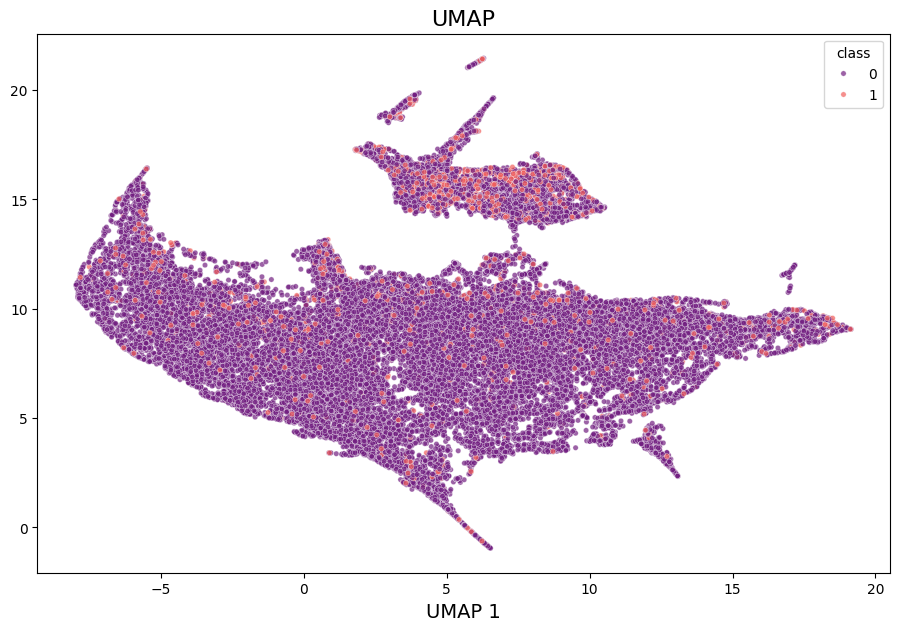

In [64]:
plt.figure(figsize=(11, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_normalized["class"], palette="magma", s=15, alpha=0.7)

plt.title('UMAP', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.show()

### **t-SNE**

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0)
X_reduced_tsne = tsne.fit_transform(X)

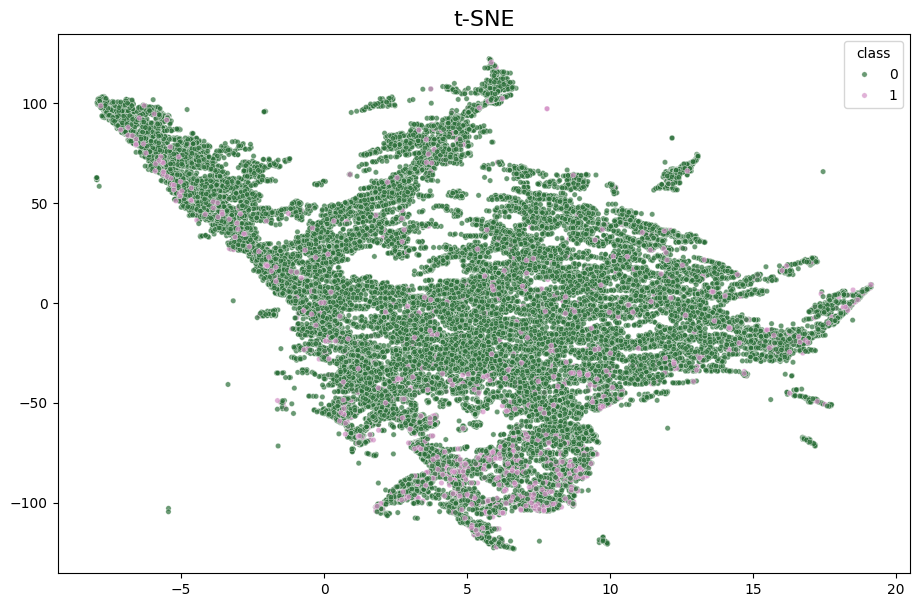

In [66]:
plt.figure(figsize=(11, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced_tsne[:, 1], hue=df_normalized["class"], palette="cubehelix", s=15, alpha=0.7)

plt.title('t-SNE', fontsize=16)
plt.show()

**redukcja wymiarów**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

accuracies = []
grouped = df_normalized.groupby('year')

In [ ]:
X = df_normalized[data_cols]
y = df_normalized['class']
test_range = range(2, 64, 2)
for n_components in test_range:
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_reduced, y, cv=5)
    accuracies.append(scores.mean())

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(test_range, accuracies, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Model Performance for Different Number of Dimensions')
plt.show()

## **Klasyfikacja💶❌**
### **wszystkie wymiary**

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score


def pipeline(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    dt_classifier = DecisionTreeClassifier(random_state = 42)
    dt_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = dt_classifier.predict(X_test)

    # Evaluating the model
    tree_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree Classifier: {tree_acc}")

    xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = xgb_classifier.predict(X_test)

    # Evaluating the model
    xgb_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy of XGBoost Classifier: {xgb_acc}")
    return (tree_acc, xgb_acc)


# Grouping the DataFrame by 'year'
grouped = df_normalized.groupby('year')

results = {
    "Year": [],
    "Model": [],
    "Accuracy": []
}
years = []
for year, group in grouped:
    results["Year"] += [f"{year}st", f"{year}st"]
    print(f"Processing year: {year}")
    X = group[data_cols]
    y = group['class']
    res = pipeline(X, y)
    results["Model"] += ["DecisionTreeClassifier", "XGBoost Classifier"]
    results["Accuracy"] += list(res)

Processing year: 1
Accuracy of Decision Tree Classifier: 0.9398951189995967
Accuracy of XGBoost Classifier: 0.9713594191206132
Processing year: 2
Accuracy of Decision Tree Classifier: 0.9343493552168816
Accuracy of XGBoost Classifier: 0.9644392340758109
Processing year: 3
Accuracy of Decision Tree Classifier: 0.9248434237995825
Accuracy of XGBoost Classifier: 0.9672929714683368
Processing year: 4
Accuracy of Decision Tree Classifier: 0.9298319327731093
Accuracy of XGBoost Classifier: 0.9689075630252101
Processing year: 5
Accuracy of Decision Tree Classifier: 0.9448315911730546
Accuracy of XGBoost Classifier: 0.9732868757259001


In [34]:
df_results = pd.DataFrame(data=results)

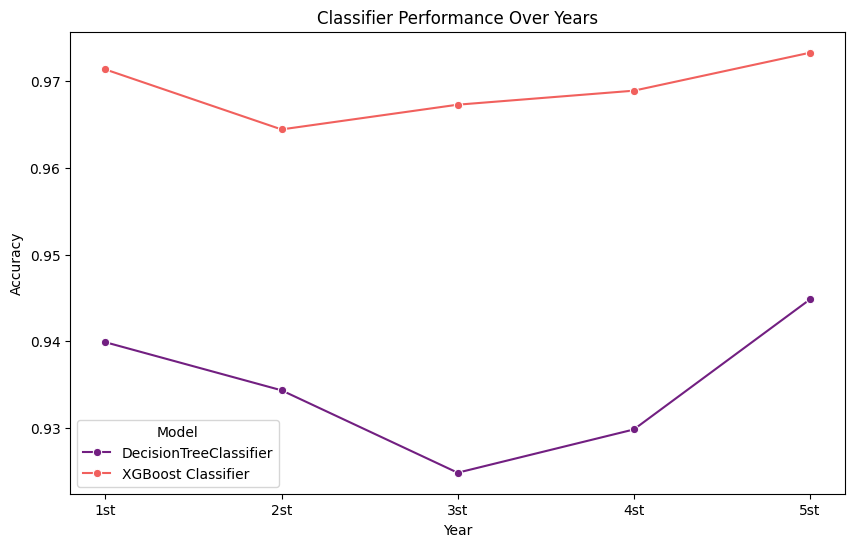

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='Year', y='Accuracy', hue='Model', marker='o', palette="magma")
plt.title('Classifier Performance Over Years')
plt.ylabel('Accuracy')
plt.xlabel('Year')
plt.xticks(list(set(results["Year"])))  # Ensure all years are shown
plt.show()